In [1]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

import numpy as np
# import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

from tokenizer import PatchTokenization

device = torch.device("mps" if torch.mps.is_available() else "cpu")

root = '/Users/carivs/Documents/My space/Projects/sign-language-translation'

In [2]:
device

device(type='mps')

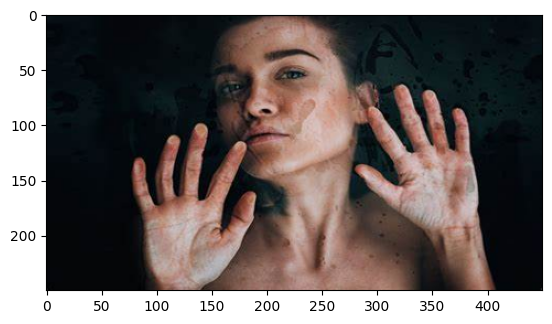

In [2]:
# Read image and convert to tensor
img = Image.open(os.path.join(root, "assets/images/hands_image.jpeg")).resize((450, 250))
plt.imshow(img)
plt.show()
# img = np.array(img)
# # print(img.shape)
# # print(np.gcd(img.shape[0], img.shape[1]))
# tokens = Patch_Tokenization()

# Patch tokenization

There will be 45 patches, each 50 by 50.
Height: 250, Width: 450



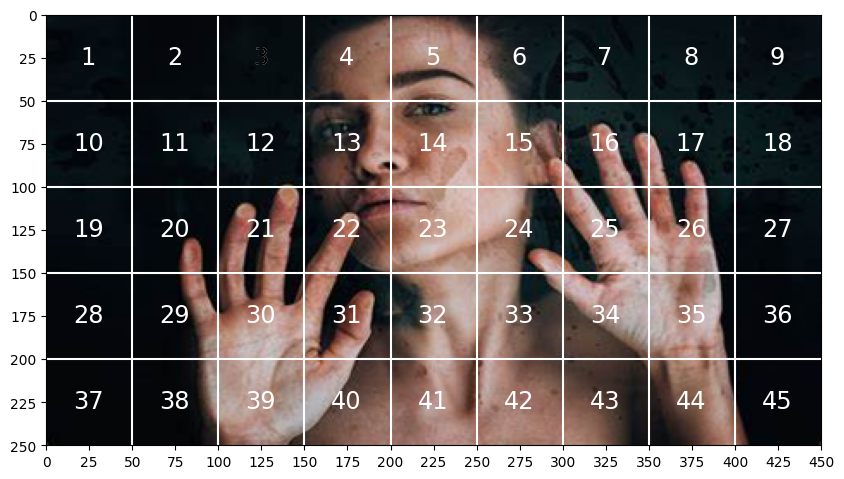

In [3]:
P = 50
W, H = img.size
N = int((H*W)/(P**2))
print('There will be', N, 'patches, each', P, 'by', str(P)+'.')
print(f'Height: {H}, Width: {W}\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(img, cmap='Purples_r')
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w')
plt.xticks(np.arange(-0.5, W+1, 25), labels=np.arange(0, W+1, 25))
plt.yticks(np.arange(-0.5, H+1, 25), labels=np.arange(0, H+1, 25))
x_text = np.tile(np.arange(24, W, P), 5)
y_text = np.repeat(np.arange(28, H, P), 9)
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='xx-large', ha='center')
plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center')
plt.show()
#plt.savefig(os.path.join(figure_path, 'mountain_patches.png'), bbox_inches='tight'

Each patch will make a token of length 2500.


([], [])

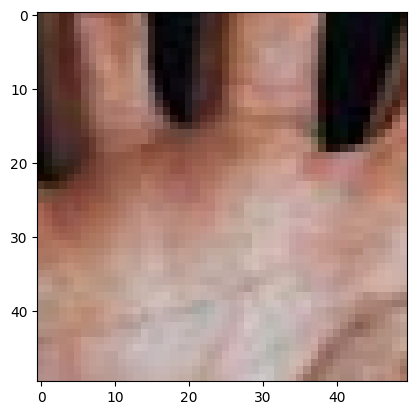

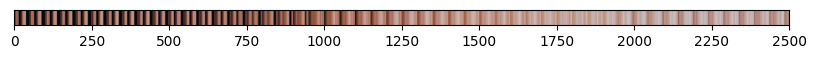

In [4]:
print('Each patch will make a token of length', str(P**2)+'.')

patch30 = np.array(img)[150:200, 100:150]
plt.imshow(patch30, cmap='Purples_r')
token12 = patch30.reshape(1, P**2, 3)

fig = plt.figure(figsize=(10,4))
plt.imshow(token12, aspect=50, cmap='Purples_r')
plt.clim([0,1])
plt.xticks(np.arange(-0.5, 2501, 250), labels=np.arange(0, 2501, 250))
plt.yticks([])
#plt.savefig(os.path.join(figure_path, 'mountain_token12.png'), bbox_inches='tight')

In [5]:
x = torch.from_numpy(np.array(img)).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
token_len = 768
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

# Define the Module
patch_tokens = PatchTokenization(img_size=(x.shape[1], x.shape[2], x.shape[3]),
                                    patch_size = P,
                                    token_len = token_len)

# x = patch_tokens.split(x).transpose(2,1)
# print('After patch tokenization, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

# x = patch_tokens.project(x)
# print('After projection, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

x = patch_tokens(x)
print('After patch tokenization, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Input dimensions are
	batchsize: 1 
	number of input channels: 3 
	image size: (250, 450)
After patch tokenization, dimensions are
	batchsize: 1 
	number of tokens: 45 
	token length: 768


In [6]:
x.shape

torch.Size([1, 45, 768])

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int, max_sequence_length:int, num_patches:int):
        super().__init__()
        
        # Spatial Positional Encoding
        self.spe = nn.Parameter(torch.zeros(num_patches, 1, d_model))
        
        # Temporal Positional Encoding
        even_i = torch.arange(0, d_model, 2, dtype=torch.float)
        den = 10000 ** (even_i / d_model)
        pos = torch.arange(max_sequence_length, dtype=torch.float).unsqueeze(1)
        self.tpe = torch.stack((torch.sin(pos / den), torch.cos(pos / den)), dim=-1)
        self.tpe = self.tpe.flatten(-2, -1)#.unsqueeze(-2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x: (batch_size, num_patches, num_frames/max_sequence_length, d_model)
        return x + self.spe + self.tpe

In [8]:
sequence_length = 10 # Number of tokens
num_patches = 4 # Number of patches
batch_size = 2
input_size = 6
d_model = 128
num_heads = 8
drop_prob = 0.1
ffn_hidden_size = d_model * 4
num_layers = 5
x = torch.randn(batch_size, num_patches, sequence_length, d_model) # Value to feed into the multi-head attention
y = torch.randn(batch_size, sequence_length, d_model) # Value to feed into the masked multi-head attention
x.size()

torch.Size([2, 4, 10, 128])

In [9]:
posEnc = PositionalEncoding(d_model, sequence_length, num_patches)
# posEnc(x).size()
posEnc(x).size()

torch.Size([2, 4, 10, 128])

In [10]:
from helpers import scaled_dot_product_attention
from typing import Literal

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model:int, num_heads:int, focus:Literal['sequence','gloss']='sequence', in_encoder:bool=True):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
        
        self.focus = focus
        self.in_encoder = in_encoder
        
    def forward(self, x:torch.Tensor, mask:torch.Tensor=None) -> torch.Tensor:
        qkv = self.qkv_layer(x) # Apply the linear transformation
        if self.in_encoder:
            batch_size, num_patches, sequence_length, _ = x.size() # Get the batch size and sequence length
            qkv = qkv.reshape(batch_size, num_patches, sequence_length, self.num_heads, 3 * self.head_dim) # Reshape the output to split the heads
            qkv = qkv.permute(0, 1, 3, 2, 4) if self.focus == 'sequence'\
                else qkv.permute(0, 2, 3, 1, 4) # Permute the dimensions to get the heads in the second dimension
        else:
            batch_size, sequence_length, _ = x.size() # Get the batch size and sequence length
            qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim) # Reshape the output to split the heads
            qkv = qkv.permute(0, 2, 1, 3) # Permute the dimensions to get the heads in the third dimension
        q, k, v = qkv.chunk(3, dim=-1) # Split the query, key and value for each head
        values, attention = scaled_dot_product_attention(q, k, v, mask) # Apply the scaled dot-product attention
        values = values.reshape(*x.shape) # Reshape the values to concatenate the heads
        values = self.linear_layer(values) # Apply the linear transformation to get the final output
        
        return values, attention

In [11]:
mha = MultiHeadAttention(d_model, num_heads, focus='gloss')
output = mha(x)
output[0].size(), output[1].size()

(torch.Size([2, 4, 10, 128]), torch.Size([2, 10, 8, 4, 4]))

In [12]:
class MultiHeadCrossAttention(nn.Module):
    # def __init__(self, d_model:int, num_heads:int):
    def __init__(self, d_model:int, num_heads:int, num_patches:int):
        super().__init__()
        # self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.q_layer = nn.Linear(d_model, d_model)
        self.kv_layer = nn.Linear(d_model, 2 * d_model)
        # self.linear_layer = nn.Linear(d_model, d_model)
        self.linear_layer = nn.Linear(d_model * num_patches, d_model)
        
    def forward(self, x:torch.Tensor, y:torch.Tensor, mask:torch.Tensor=None) -> torch.Tensor:
        batch_size, num_patches, sequence_length, d_model = x.size() # Get the batch size and sequence length
        
        q = self.q_layer(y) # Apply the linear transformation
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim) # Reshape the output to split the heads
        q = q.permute(0, 2, 1, 3) # Permute the dimensions to get the heads in the third dimension
        
        kv = self.kv_layer(x) # Apply the linear transformation
        kv = kv.reshape(batch_size, num_patches, sequence_length, self.num_heads, 2 * self.head_dim) # Reshape the output to split the heads
        kv = kv.permute(1, 0, 3, 2, 4) # Permute the dimensions to get the heads in the third dimension and batch size in the second to align with q
        k, v = kv.chunk(2, dim=-1) # Split the query, key and value for each head
        
        values, attention = scaled_dot_product_attention(q, k, v, mask) # Apply the scaled dot-product attention
        #TODO: Adjust the attention to have lower dimensions using linear transformation
        attention = attention.permute(1, 0, 2, 3, 4) # Permute the dimensions to get the heads in the second dimension
        # values = values.reshape(batch_size, num_patches, sequence_length, d_model) # Reshape the values to concatenate the heads
        values = values.reshape(batch_size, sequence_length, d_model * num_patches) # Reshape the values to concatenate the heads
        values = self.linear_layer(values) # Apply the linear transformation to get the final output
        
        return values, attention

In [13]:
mhca = MultiHeadCrossAttention(d_model, num_heads, num_patches)
output = mhca(x,y)
output[0].size(), output[1].size()

(torch.Size([2, 10, 128]), torch.Size([2, 4, 8, 10, 10]))

In [14]:
class LayerNormalization(nn.Module):
    def __init__(self, params_shape:list[int], eps:float=1e-6):
        super().__init__()
        self.params_shape = params_shape
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(params_shape))
        self.beta = nn.Parameter(torch.zeros(params_shape))
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        dims = [-(i + 1) for i in range(len(self.params_shape))]
        mean = x.mean(dim=dims, keepdim=True)
        std = x.std(dim=dims, keepdim=True) + self.eps
        y = self.gamma * (x - mean) / std + self.beta
        return y

In [15]:
# x2 = x.permute(1, 0, 2) # Transpose the input tensor to compute batch normalization
ln = LayerNormalization(x.size()[-2:])
ln(x).size()

torch.Size([2, 4, 10, 128])

In [16]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model:int, hidden_size:int, drop_prob:float):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_size),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_size, d_model)
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.ffn(x)

In [17]:
FeedForwardNetwork(d_model, ffn_hidden_size, drop_prob)(x).size()

torch.Size([2, 4, 10, 128])

In [18]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model:int, ffn_hidden_size:int, num_heads:int, drop_prob:float):
        super().__init__()
        self.mhga = MultiHeadAttention(d_model, num_heads, focus='gloss', in_encoder=True)
        self.norm1 = LayerNormalization([d_model])
        self.dropout1 = nn.Dropout(drop_prob)
        self.mhsa = MultiHeadAttention(d_model, num_heads, focus='sequence', in_encoder=True)
        self.norm2 = LayerNormalization([d_model])
        self.dropout2 = nn.Dropout(drop_prob)
        self.ffn = FeedForwardNetwork(d_model, ffn_hidden_size, drop_prob)
        self.norm3 = LayerNormalization([d_model])
        self.dropout3 = nn.Dropout(drop_prob)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        residual = x
        x, _ = self.mhga(x)
        x = self.norm1(x + residual)
        x = self.dropout1(x)
        residual = x
        x, _ = self.mhsa(x)
        x = self.norm2(x + residual)
        x = self.dropout2(x)
        residual = x
        x = self.ffn(x)
        x = self.dropout3(x)
        x = self.norm3(x + residual)
        return x

In [19]:
class Encoder(nn.Module):
    def __init__(self, d_model:int, ffn_hidden_size:int, num_heads:int, num_layers:int, drop_prob:float):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden_size, num_heads, drop_prob) for _ in range(num_layers)])
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x

In [20]:
enc = Encoder(d_model, ffn_hidden_size, num_heads, num_layers, drop_prob)
out_enc = enc(x)
out_enc.size()

torch.Size([2, 4, 10, 128])

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model:int, ffn_hidden_size:int, num_heads:int, num_patches:int, drop_prob:float):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads, focus='sequence', in_encoder=False)
        self.norm1 = LayerNormalization([d_model])
        self.dropout1 = nn.Dropout(drop_prob)
        self.mhca = MultiHeadCrossAttention(d_model, num_heads, num_patches)
        self.norm2 = LayerNormalization([d_model])
        self.dropout2 = nn.Dropout(drop_prob)
        self.ffn = FeedForwardNetwork(d_model, ffn_hidden_size, drop_prob)
        self.norm3 = LayerNormalization([d_model])
        self.dropout3 = nn.Dropout(drop_prob)
        
    def forward(self, x:torch.Tensor, y:torch.Tensor, mask:torch.Tensor) -> torch.Tensor:
        residual = y
        y, _ = self.mha(y, mask)
        y = self.norm1(y + residual)
        y = self.dropout1(y)
        residual = y
        y, _ = self.mhca(x, y)
        y = self.norm2(y + residual)
        y = self.dropout2(y)
        residual = y
        y = self.ffn(y)
        y = self.norm3(y + residual)
        y = self.dropout3(y)
        return y

In [22]:
class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs) -> torch.Tensor:
        x, y, mask = inputs
        for module in self._modules.values():
            y = module(x, y, mask)
        return y

In [23]:
class Decoder(nn.Module):
    def __init__(self, d_model:int, ffn_hidden_size:int, num_heads:int, num_layers:int, num_patches:int, drop_prob:float):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden_size, num_heads, num_patches, drop_prob) for _ in range(num_layers)])
    
    def forward(self, x:torch.Tensor, y:torch.Tensor, mask:torch.Tensor) -> torch.Tensor:
        x = self.layers(x, y, mask)
        return x

In [24]:
dec = Decoder(d_model, ffn_hidden_size, num_heads, num_layers, num_patches, drop_prob)
out_dec = dec(x, y, mask=None)
out_dec.size()

torch.Size([2, 10, 128])

In [4]:
# from pytorch_i3d import InceptionI3d

# model = InceptionI3d(num_classes=400, in_channels=3)
# model.load_state_dict(torch.load('rgb_imagenet.pt'))
# model.eval()

# embeddings = model(video_tensor)  # video_tensor: [batch, channels, frames, height, width]

In [8]:
# from phoenix_datasets import PhoenixVideoTextDataset

# from torch.utils.data import DataLoader

# dtrain = PhoenixVideoTextDataset(
#     # your path to this folder, download it from official website first.
#     root="/Users/carivs/Documents/My space/Projects/datasets/PHOENIX-2014-T-release-v3/PHOENIX-2014-T",
#     split="PHOENIX-2014-T.train",
#     p_drop=0.5,
#     random_drop=True,
#     random_crop=True,
#     base_size=[256, 256],
#     crop_size=[224, 224],
# )

# vocab = dtrain.vocab

# print("Vocab", vocab)

# dl = DataLoader(dtrain, collate_fn=dtrain.collate_fn)

# for batch in dl:
#     video = batch["video"]
#     label = batch["label"]
#     signer = batch["signer"]

#     assert len(video) == len(label)

#     print(len(video))
#     print(video[0].shape)
#     print(label[0].shape)
#     print(signer)

#     break

In [7]:
# Read npy file
X = np.load(os.path.join(root, "assets/X.npy"), allow_pickle=True)
y = np.load(os.path.join(root, "assets/Y.npy"), allow_pickle=True)
X.shape, y.shape

((2062, 64, 64), (2062, 10))